# Reproduce the Laplace-approximated NAM
## References
```  
@misc{bouchiat2023laplaceapproximated,
      title={Laplace-Approximated Neural Additive Models: Improving Interpretability with Bayesian Inference}, 
      author={Kouroche Bouchiat and Alexander Immer and Hugo Yèche and Gunnar Rätsch and Vincent Fortuin},
      year={2023},
      eprint={2305.16905},
      archivePrefix={arXiv},
      primaryClass={stat.ML}
}
```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters

from LANAM.models import LaNAM, BayesianLinearRegression

from LANAM.config.default import defaults

from LANAM.trainer.training import *
from LANAM.trainer.marglik_training import *

from LANAM.data.generator import *
from LANAM.data.toydataset import ToyDataset

from LANAM.utils.plotting import * 

import matplotlib.pyplot as plt 
import numpy as np


from laplace import Laplace
from laplace import marglik_training as lamt
from laplace.curvature.backpack import BackPackGGN
"""
Reference:
@misc{kayid2020nams,
  title={Neural additive models Library},
  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},
  year={2020}
}
"""

'\nReference:\n@misc{kayid2020nams,\n  title={Neural additive models Library},\n  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},\n  year={2020}\n}\n'

In [2]:
%reload_ext autoreload 
%autoreload 2

## test: linear toy data
1. dataset: $y \sim N(f(x), \sigma^2)$, where $f(x) = 0.3x-0.7, \sigma = 0.2$.
2. model: Bayesian linear regression, Linear layer with laplace approximation, LA-NAM

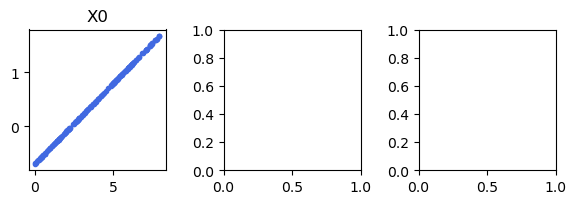

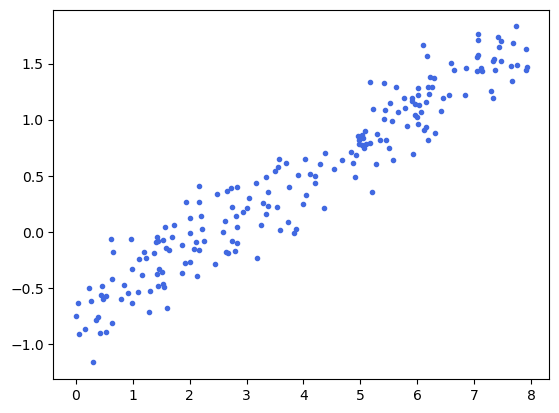

In [12]:
sigma = 0.2
x_start, x_end = 0, 8
num_samples = 200
gen_funcs, gen_func_names = [linear_shape], ['linear']

trainset = ToyDataset(gen_funcs, gen_func_names, num_samples=num_samples, sigma=sigma, x_start=x_start, x_end=x_end)
valset = ToyDataset(gen_funcs, gen_func_names, num_samples=num_samples, sigma=sigma, x_start=x_start, x_end=x_end)
testset = ToyDataset(gen_funcs, gen_func_names, num_samples=50, use_test=True, x_start=x_start, x_end=x_end)

trainset.plot()


In [13]:
def get_blr(X, y): 
    return BayesianLinearRegression(X, y)

def get_lanam(in_features, cfg):
    return LaNAM(
            config=cfg, 
            name="LaNAM", 
            in_features=in_features, 
            hessian_structure='full')

def get_linear_model(): 
    return nn.Linear(1, 1)

In [14]:
cfg = defaults()
cfg.hidden_sizes = []

in_features = trainset.in_features

X_train, y_train, train_loader, train_loader_fnn = trainset.X, trainset.y, trainset.loader, trainset.loader_fnn
X_val, y_val, val_loader, val_loader_fnn = valset.X, valset.y, valset.loader, valset.loader_fnn
X_test, y_test = testset.X, testset.y

In [15]:
blr = get_blr(X_train, y_train)

In [16]:
cfg.activation = False
lanam = get_lanam(in_features, cfg)
print(lanam)
loss = train(cfg, lanam, train_loader, val_loader)
lanam.fit(loss, train_loader)

LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0): FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1, bias=True)
      )
    )
  )
)
=============EPOCH 1==============
loss_train:  19.441, loss_val:  17.997
=============EPOCH 101==============
loss_train:  0.093, loss_val:  0.081
=============EPOCH 201==============
loss_train:  0.050, loss_val:  0.037
=============EPOCH 301==============
loss_train:  0.044, loss_val:  0.031
Finished Training.


MSE loss:  0.0004
Additive sigma noise:  1.0000
Individual sigma noise: [1.]
Mean of additive predictive posterior std:  1.0050
Mean of individual predictive posterior std: [1.0049623]
(-2.1488935947418213, 2.2540074586868286)


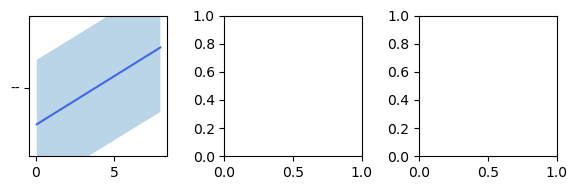

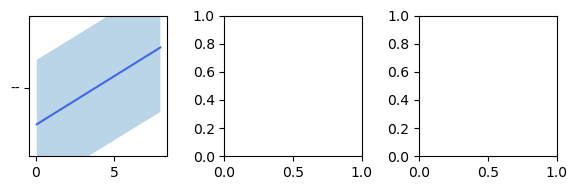

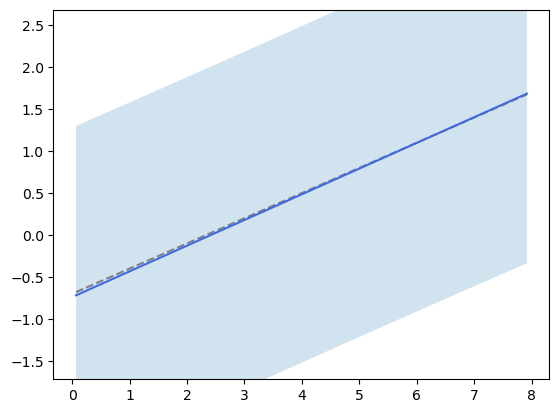

In [22]:
fig_addi, fig_indiv = plot_predictive_posterior(lanam, testset)
fig_indiv

In [38]:
print(lanam.loss)

tensor(4.2892)


In [39]:
linear_model = get_linear_model()
params = parameters_to_vector(lanam.feature_nns[0].parameters()).detach()
print(params)
vector_to_parameters(params, linear_model.parameters()) # assign nam and linear layer the same parameters
# loss = train(cfg, linear_model, train_loader, val_loader)
la = Laplace(linear_model, 'regression', subset_of_weights='all', hessian_structure='full')
la.fit(train_loader)

tensor([ 0.3058, -0.7181])


In [40]:
np.testing.assert_allclose(la.posterior_precision, lanam.posterior_precision, atol=1e-3)
np.testing.assert_allclose(blr.posterior_precision, lanam.posterior_precision, atol=1e-3)

np.testing.assert_allclose(la.posterior_covariance, lanam.posterior_covariance, atol=1e-3)

f_mu_blr, f_var_blr = blr.predict(testset.X)
f_mu_la, f_var_la = la(testset.X)
f_mu_lanam, f_var_lanam, fnn_mu, fnn_var = lanam.predict(testset.X)

#np.testing.assert_allclose(f_var_blr.flatten(), f_var_la.flatten(), atol=1e-6)
np.testing.assert_allclose(f_var_lanam.flatten(), f_var_la.flatten(), atol=1e-3)

np.testing.assert_allclose(f_mu_blr.flatten(), f_mu_lanam.flatten(), atol=1e-1)
np.testing.assert_allclose(f_mu_la.flatten(), f_mu_lanam.flatten(), atol=1e-3)

MSE loss:  0.0002
Additive sigma noise:  1.0000
Individual sigma noise: [1.]
Mean of additive predictive posterior std:  1.0053
Mean of individual predictive posterior std: [1.0052879]


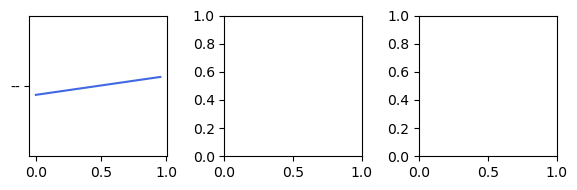

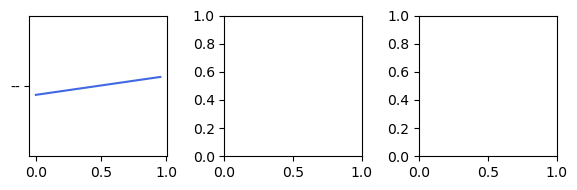

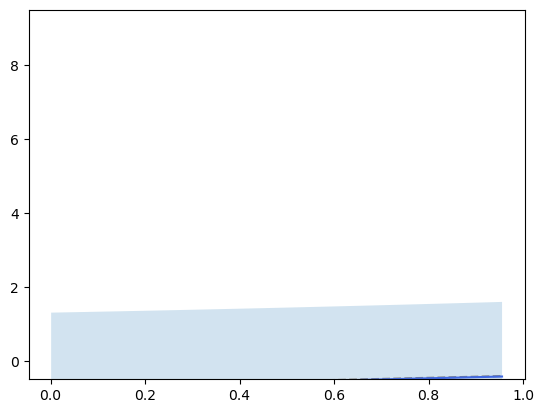

In [45]:
fig_addit, fig_indiv = plot_predictive_posterior(lanam, testset)
fig_indiv

### post-hoc tuning

In [11]:
# la-nam
n_epochs = 1000
log_prior, log_sigma = torch.ones(in_features, requires_grad=True), torch.ones(in_features, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - lanam.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [12]:
# laplace-torch
n_epochs = 1000
log_prior_, log_sigma_ = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior_, log_sigma_], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior_.exp(), log_sigma_.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [13]:
# Bayesian linear regression
n_epochs = 1000
log_sigma = torch.ones(1, requires_grad=True) # log std deviation of the regression Gaussian noise
log_prior_var = torch.ones(1, requires_grad=True) # log variance of parameter prior 
lr = 1e-1
optimizer = torch.optim.Adam([log_prior_var, log_sigma], lr=lr)
for epoch in range(n_epochs): 
    optimizer.zero_grad()
    neg_log_marg_lik = -blr.log_marginal_likelihood(log_prior_var.exp(), log_sigma.exp())
    neg_log_marg_lik.backward()
    optimizer.step()

In [14]:
from math import sqrt, pi
print(lanam.sigma_noise, la.sigma_noise)
print(lanam.prior_precision, la.prior_precision)

print(lanam._H_factor, la._H_factor)
print(lanam.n_data, la.n_data)
print(lanam.n_outputs, la.n_outputs)
print(lanam.loss, la.loss)

print(lanam.posterior_covariance, la.posterior_covariance)
print(lanam.log_likelihood, la.log_likelihood)
print(lanam.log_marginal_likelihood(), la.log_marginal_likelihood())

tensor([0.2081], grad_fn=<MulBackward0>) tensor(0.2080, grad_fn=<SelectBackward0>)
tensor([2.6960], grad_fn=<MulBackward0>) tensor([2.6960], grad_fn=<ExpBackward0>)
tensor(23.0922, grad_fn=<DivBackward0>) tensor(23.1129, grad_fn=<DivBackward0>)
200 200
1 1
tensor(4.2874) tensor(4.2835)
tensor([[ 0.0025, -0.0013],
        [-0.0013,  0.0009]], grad_fn=<MmBackward0>) tensor([[ 0.0025, -0.0013],
        [-0.0013,  0.0009]], grad_fn=<MmBackward0>)
tensor(31.1573, grad_fn=<SubBackward0>) tensor(31.2469, grad_fn=<SubBackward0>)
tensor(23.9369, grad_fn=<SubBackward0>) tensor(24.0256, grad_fn=<SubBackward0>)


In [15]:
sigma_lanam = lanam.sigma_noise.detach() 
sigma_la = la.sigma_noise.detach()
prior_lanam = lanam.prior_precision.detach()
prior_la = la.prior_precision.detach()

sigma_blr = blr.sigma_noise.detach()
prior_blr = blr.prior_precision.detach()

print(sigma_la, sigma_lanam, sigma_blr)
print(prior_la, prior_lanam, prior_blr)
np.testing.assert_allclose(sigma_la, sigma_lanam, atol=1e-2)
np.testing.assert_allclose(prior_la, prior_lanam, atol=1e-1)

tensor(0.2080) tensor([0.2081]) tensor([0.2080])
tensor([2.6960]) tensor([2.6960]) tensor([2.7323])


In [16]:
f_mu_blr, f_var_blr = blr.predict(testset.X)
f_mu_la, f_var_la = la(testset.X)
f_mu_lanam, f_var_lanam, fnn_mu, fnn_var = lanam.predict(testset.X)

#np.testing.assert_allclose(f_var_blr.flatten(), f_var_la.flatten(), atol=1e-6)
np.testing.assert_allclose(f_var_lanam.flatten(), f_var_la.flatten(), atol=1e-3)

np.testing.assert_allclose(f_mu_blr.detach().numpy().flatten(), f_mu_lanam.flatten(), atol=1e-1)
np.testing.assert_allclose(f_mu_la.flatten(), f_mu_lanam.flatten(), atol=1e-3)

### online tuning

In [17]:
linear_model = get_linear_model()
n_epochs = 300
la, linear_model, margliks, losses = lamt(
    model=linear_model, train_loader=train_loader, likelihood='regression',
    hessian_structure='full', backend=BackPackGGN, n_epochs=n_epochs, 
    optimizer_kwargs={'lr': 1e-2}, prior_structure='scalar'
)

In [18]:
lanam = get_lanam(in_features, cfg)
print(lanam)
lanam, margliks, losses, perfs = marglik_training(
    lanam, train_loader, train_loader, likelihood='regression', n_epochs=n_epochs, optimizer_kwargs={'lr': 1e-2})

LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0): FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.045, epoch_perf= 0.045
tensor([3.7522], grad_fn=<ExpBackward0>) tensor([0.2125], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.043, epoch_perf= 0.043
tensor([2.8102], grad_fn=<ExpBackward0>) tensor([0.2086], grad_fn=<ExpBackward0>)
MARGLIK: finished training. Recover best model and fit Laplace.


In [19]:
params = parameters_to_vector(lanam.feature_nns[0].parameters()).detach()
print(params, blr.mean.flatten(), la.mean)

tensor([ 0.3558, -0.7695]) tensor([ 0.3673, -0.7705], grad_fn=<ReshapeAliasBackward0>) tensor([ 0.3673, -0.7703])


In [20]:
from math import sqrt, pi
print(lanam.sigma_noise, la.sigma_noise)
print(lanam.prior_precision, la.prior_precision)

print(lanam._H_factor, la._H_factor)
print(lanam.n_data, la.n_data)
print(lanam.n_outputs, la.n_outputs)
print(lanam.loss, la.loss)

print(lanam.posterior_covariance, la.posterior_covariance)
print(lanam.log_likelihood, la.log_likelihood)
print(lanam.log_marginal_likelihood(), la.log_marginal_likelihood())

tensor([0.2082], grad_fn=<MulBackward0>) tensor(0.2081)
tensor([2.6105], grad_fn=<MulBackward0>) tensor([2.7222])
tensor(23.0632, grad_fn=<DivBackward0>) tensor(23.0995)
200 200
1 1
tensor(4.2938) tensor(4.2836)
tensor([[ 0.0025, -0.0013],
        [-0.0013,  0.0009]], grad_fn=<MmBackward0>) tensor([[ 0.0025, -0.0013],
        [-0.0013,  0.0009]])
tensor(31.0084, grad_fn=<SubBackward0>) tensor(31.2441)
tensor(23.7570, grad_fn=<SubBackward0>) tensor(24.0373)


In [21]:
sigma_lanam = lanam.sigma_noise.detach() 
sigma_la = la.sigma_noise.detach()
prior_lanam = lanam.prior_precision.detach()
prior_la = la.prior_precision.detach()
sigma_blr = blr.sigma_noise.detach()
prior_blr = blr.prior_precision.detach()
print(sigma_la, sigma_lanam, sigma_blr)
print(prior_la, prior_lanam, prior_blr)
np.testing.assert_allclose(sigma_la, sigma_lanam, atol=1e-2)
np.testing.assert_allclose(prior_la, prior_lanam, atol=1)

tensor(0.2081) tensor([0.2082]) tensor([0.2080])
tensor([2.7222]) tensor([2.6105]) tensor([2.7323])


In [26]:
f_mu_blr, f_var_blr = blr.predict(testset.X)
f_mu_la, f_var_la = la(testset.X)
pred_var_la = f_var_la.detach().numpy().flatten() + la.sigma_noise.detach().square().numpy()
f_mu_lanam, f_var_lanam, fnn_mu, fnn_var = lanam.predict(testset.X)
pred_var_lanam = f_var_lanam.detach().numpy().flatten() + lanam.sigma_noise.detach().square().numpy()

np.testing.assert_allclose(f_var_blr.detach().numpy().flatten(), pred_var_la, atol=1e-3)
np.testing.assert_allclose(pred_var_lanam.flatten(), pred_var_la, atol=1e-3)

np.testing.assert_allclose(f_mu_blr.detach().numpy().flatten(), f_mu_lanam.flatten(), atol=1e-1)
np.testing.assert_allclose(f_mu_la.flatten(), f_mu_lanam.flatten(), atol=1e-1)

### activation units

In [93]:
lanams = dict()
acti_clses = ['gelu', 'relu', 'elu', 'leakyrelu']
cfg.activation = True
cfg.hidden_sizes = [64]
for acti_cls in acti_clses:
    cfg.activation_cls = acti_cls
    print(f'LA-NAM with {acti_cls} activation unit: ')
    model = LaNAM(config=cfg, name="LaNAM", in_features=in_features, hessian_structure='full', subset_of_weights='all', sigma_noise=0.2)
    print(model)
    model, margliks, losses, perfs = marglik_training(
    model, train_loader, train_loader_fnns, likelihood='regression', n_epochs=1000, optimizer_kwargs={'lr': 1e-2})
    lanams[acti_cls] = model

LA-NAM with gelu activation unit: 
LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0): FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.046, epoch_perf= 0.039
tensor([1.4664], grad_fn=<ExpBackward0>) tensor([0.1731], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.038, epoch_perf= 0.038
tensor([1.3095], grad_fn=<ExpBackward0>) tensor([0.1871], grad_fn=<ExpBackward0>)
EPOCH=301: epoch_loss= 0.038, epoch_perf= 0.037
tensor([1.2624], grad_fn=<ExpBackward0>) tensor([0.1930], grad_fn=<ExpBackward0>)
EPOCH=401: epoch_loss= 0.037, epoch_perf= 0.037
tensor([1.3243], grad_fn=<ExpBackward0>) tensor([0.1933], grad_fn=<ExpBackward0>)
EPOCH=501: epoch_loss= 0.038, epoch_perf= 0.038
tensor([1.3855], grad_fn=<ExpBackward0>) tensor([0.1951], grad_fn=<ExpBackward0>)
EPOCH=601: epoch_loss= 

In [109]:
import os
output_dir = './output/linear_reg_test/20230807/'
os.makedirs(output_dir, exist_ok=True)
for idx, acti_cls in enumerate(acti_clses):
    pth = output_dir + acti_cls + '.pt'
    torch.save(lanams[acti_cls].state_dict(), pth)

Bayesian Linear Regression:
-----------------
Sigma noise:  0.1926
Standard deviation:  0.1936

 LA-NAM with gelu activation unit: 
-----------------
Loss:  0.0014
Sigma noise:  0.1942
Standard deviation:  0.2199

 LA-NAM with relu activation unit: 
-----------------
Loss:  0.0006
Sigma noise:  0.1956
Standard deviation:  0.2335

 LA-NAM with elu activation unit: 
-----------------
Loss:  0.0006
Sigma noise:  0.1935
Standard deviation:  0.2517

 LA-NAM with leakyrelu activation unit: 
-----------------
Loss:  0.0008
Sigma noise:  0.1951
Standard deviation:  0.2720


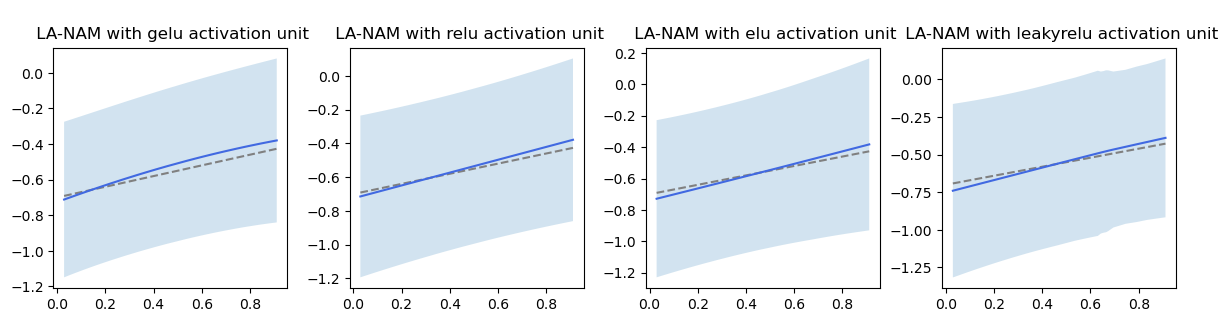

In [106]:
X, y, fnn = testset.X, testset.y, testset.fnn
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs = axs.ravel()
fig.tight_layout()

print('Bayesian Linear Regression:')
print('-----------------')
f_mu_blr, f_mu_var = blr.predict(testset.X)
std = np.sqrt(f_mu_var.detach().numpy())
print(f'Sigma noise: {blr.sigma_noise.detach().numpy().item(): .4f}')
print(f'Standard deviation: {std.mean().item(): .4f}')
for idx, acti_cls in enumerate(acti_clses):
    print(f'\n LA-NAM with {acti_cls} activation unit: ')
    print('-----------------')
    f_mu, f_var, f_mu_fnn, f_var_fnn = lanams[acti_cls].predict(X)
    pred_var_fnn = f_var_fnn.detach().numpy() + lanams[acti_cls].sigma_noise.detach().square().numpy()
    pred_var = f_var.detach().numpy() + lanams[acti_cls].additive_sigma_noise.detach().square().numpy()
    std = np.sqrt(pred_var).flatten()
    
    axs[idx].plot(X[:, 0].flatten(), y.flatten(), '--', label="targeted", color="gray")
    axs[idx].plot(X[:, 0].flatten(), f_mu, '-', label="prediction", color="royalblue")
    axs[idx].fill_between(X[:, 0].flatten(), f_mu.flatten()-2*std, f_mu.flatten()+2*std, alpha=0.2)
    axs[idx].set_title(f'\n LA-NAM with {acti_cls} activation unit')
    
    loss = nn.functional.mse_loss(f_mu.flatten(), y.flatten())
    print(f'Loss: {loss.item(): .4f}')
    print(f'Sigma noise: {lanams[acti_cls].additive_sigma_noise.detach().numpy().item(): .4f}')
    print(f'Standard deviation: {std.mean().item(): .4f}')